<a href="https://colab.research.google.com/github/tyrannorrec/CS6120-NLP-Final-Project/blob/main/GROUP_3_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction:

We aim to classify texts in a dataset containing human-written news articles and machine-generated texts according to their origin.

Mounting of Drive, installation and importing of packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
root_path = '/content/drive/My Drive/Colab Notebooks/CS6120-NLP-Final-Project Public/'
!pip install -q transformers

import tensorflow as tf
import pandas as pd
import numpy as np
import sys
import math
import re
import string
import nltk
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns

from tqdm import tqdm
from collections import Counter
from sklearn import svm
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score, recall_score, precision_score, confusion_matrix
from nltk import ngrams
from nltk.lm.preprocessing import pad_sequence
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from transformers import pipeline, set_seed, AutoTokenizer
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4',  quiet=True)

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 96.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 110.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 27.6 MB/s eta 0:00:00


True

# Generation of machine data
Our dataset combines human written articles from the newsgroups dataset with generated texts from GPT-2 to form a dataset with 12000 entries, 6000 human written and 6000 machine written.

This code does not need to be run for the rest of the notebook to function, as the dataset is already saved and can be loaded with a simple line.

Using newsgroups dataset, use headers as input for the gpt2 generator to create machine text and use article text as a source of human text, ensuring that topics are similar. Generation was time consuming and thus done in chunks. 

In [ ]:
def fetch_and_extract_subject_lines():
    """
    Fetches the 20 newsgroups dataset and extracts subject lines.

    Returns:
        list: A list of extracted subject lines.
    """
    newsgroups_machine = fetch_20newsgroups(subset='all', remove=('footers', 'quotes'))
    print(len(newsgroups_machine.data))

    # Extract subject lines from the dataset
    subject_lines = []

    for header in newsgroups_machine.data:
        header_lines = header.split('\n')
        for subject_line in header_lines:
            if subject_line.startswith('Subject: '):
                subject_line = subject_line.replace('Subject: ', '')
                if subject_line.startswith('Re: '):
                    subject_line = subject_line.replace('Re: ', '')
                subject_lines.append(subject_line)

    return subject_lines


def generate_text_chunks(subject_lines, root_path):
    """
    Generates text chunks based on subject lines using GPT-2.

    Parameters:
        subject_lines (list): A list of subject lines.
        root_path (str): The root path where generated text chunks will be saved.
    """
    
    generator = pipeline('text-generation', model='gpt2')
    set_seed(42)


    generated_results = []

    column_names = ['subject_line', 'generated_text']
    output_df = pd.DataFrame(columns=column_names)

    chunk_size = 10

    for i in range(0, 6000, chunk_size):
        output_path = f"{root_path}20NewsGroups_dataset/chunk_machine_gen_res/{i}_to_{i+chunk_size}"
        chunk = subject_lines[i:i+chunk_size]
        generated_chunk = []

        for subject_line in chunk:
            print(subject_line)
            generator.model.config.pad_token_id = generator.model.config.eos_token_id
            generated_text = generator(subject_line, max_length=256, num_return_sequences=1)
            generated_text = list(generated_text[0].values())[0]
            generated_text = generated_text.split('.')
            
            if len(generated_text) > 1:
                generated_text = generated_text[:-1]
            
            generated_text = '.'.join(generated_text)
            generated_text = generated_text + '.'
            generated_chunk.append((subject_line, generated_text))

        chunk_df = pd.DataFrame(generated_chunk, columns=column_names)
        
        csv_file = f"{output_path}_machine_generated_results.csv"

        if not os.path.exists(csv_file):
            with open(csv_file, 'w') as f:
                f.write(','.join(column_names) + '\n')
        chunk_df.to_csv(csv_file, index=False, mode='a', header=False)

In [ ]:
subject_lines = fetch_and_extract_subject_lines()
subject_lines
generate_text_chunks(subject_lines, root_path)

Machine data is read from chunked dataframes and combined into a single dataframe. A second dataframe is created using the texts of the newsgroups articles, filtering out those that had sufficient lengths to be similar to the machine generated texts. These dataframes are labeled as 1 for machine and 0 for human and combined into a single dataframe which is saved for later use.

In [ ]:
def combine_machine_human_data(root_path):
    """
    Combines machine and human data into a single dataframe and saves it as a CSV file.

    Parameters:
        root_path (str): The root path where the combined data will be saved.
    """
    
    # Machine data
    dfs=[]
    chunk_size=10
    for i in tqdm(range(0,6000, chunk_size)):
        data_path = f"{root_path}20NewsGroups_dataset/chunk_machine_gen_res/{i}_to_{i+chunk_size}_machine_generated_results.csv"
        dfs.append(pd.read_csv(data_path))

    # Fix duplicates
    for i in range(len(dfs)):
      if not len(dfs[i])==10:
        dfs[i]=dfs[i][:10] 

    machine_data=pd.concat(dfs,axis=0,ignore_index=True)

    # Human Data
    # Remove headers, footers and quotes using builting remove functions
    newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
    # Filter to get those with at least 192 tokens
    texts=list(newsgroups.data)
    # Choose a pre-trained RoBERTa model (e.g., distilbert-base-uncased)
    model_name = "distilbert-base-uncased"
    # Load the tokenizer for the chosen model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    news_encodings=tokenizer(texts,truncation=True,padding=False,max_length=192)
    enc_lens=[len(n) for n in news_encodings['input_ids']]
    human_texts=[texts[i] for i in range(len(texts)) if enc_lens[i]>=192]

    labeled_machine=pd.DataFrame({'text':machine_data['generated_text'], 'label':[1]*6000})
    labeled_human=pd.DataFrame({'text':human_texts[:6000],'label':[0]*6000})
    all_data=pd.concat([labeled_machine,labeled_human])
    all_data=all_data.sample(frac=1, replace=True,random_state=42)
    all_data=all_data.reindex()
    all_data.to_csv(f"{root_path}20NewsGroups_dataset/all_data.csv", mode='w+', index=False)

In [ ]:
combine_machine_human_data(root_path)

# Data Preprocessing

Data preprocessing was done by cleaning the messages in the traditional way (removing stopwords, punctuation, etc) and adding beginning and end of sentence tokens for the N-grams. 

In [ ]:
data = pd.read_csv(f"{root_path}20NewsGroups_dataset/all_data.csv").dropna()
X = data.text
y = np.array(list(data.label))
n = 3

In [ ]:
# Text cleaning
def clean_message(message):
    """
    Transforms a message into a cleaned and preprocessed form.

    Args:
        message (str): The input message string.

    Returns:
        str: The cleaned and preprocessed message string.
    """
    # Lowercase the letters
    if not isinstance(message, str):
        message = message.tostring()
    message = message.lower()
    
    # Removing URLS
    message = re.sub(r"http\S+", "", message) # removes URLs starting with http 
    message = re.sub(r"www\S+", "", message) # removes URLs starting with www
    
    # Removing email address
    email_pattern = r'\S*@\S*\s?'
    message = re.sub(email_pattern, '', message, flags=re.IGNORECASE)
    
    # Removing punctuations
    string.punctuation
    message = "".join([char for char in message if char not in string.punctuation])
    
    # Removing stopwords
    stopword = nltk.corpus.stopwords.words('english')
    message = " ".join([word for word in re.split('\W+', message) if word not in stopword])
    
    # Lemmatization: similar to stemming but keep the form of verb or nouns
    wn = nltk.WordNetLemmatizer()
    message = " ".join([wn.lemmatize(word, 'v') for word in re.split('\W+', message)])
    return message

# Splitting each text into short sentences
def split_lines(text):
    """
    Splits a text into sentences.

    Parameters:
        text (str): The input text.

    Returns:
        list: A list of sentences.
    """
    text = "".join([char if char != "\n" else " " for char in text])
    lines = re.split(r'(?<=[.?!][ \[\(])|(?<=\n)\s*', text)
    return lines

# n-gram preprocessing and other related tasks
def clean_ngram_preprocess_message(message, n):
    """
    Cleans and preprocesses a message for n-grams.

    Parameters:
        message (str): The input message string.
        n (int): The size of n-grams.

    Returns:
        str: The cleaned and preprocessed message string.
    """
    SENT_BEGIN = "<s> " * (n-1)
    SENT_END = " </s>" * (n-1)

    message=clean_message(message)
    message = message.rstrip().lstrip()

    message = SENT_BEGIN + message + SENT_END
    
    return message

def clean_sentences(sentences, n):
    """
    Cleans and preprocesses sentences for n-grams.

    Parameters:
        sentences (list): A list of sentences.
        n (int): The size of n-grams.

    Returns:
        list: A list of cleaned and preprocessed sentences.
    """
    cleaned_sentences = []
    for sentence in sentences:
      cleaned_sentences.append(clean_ngram_preprocess_message(sentence, n))
    return cleaned_sentences

# Dataset Preprocessing
def clean_preprocess(dataset):
    """
    Cleans and preprocesses a dataset.

    Parameters:
        dataset (list): The dataset.

    Returns:
        list: A list of cleaned and preprocessed texts.
    """
    return [clean_message(x).split() for x in dataset]


def ngram_preprocess(dataset, n):
    """
    Preprocesses a dataset for n-grams.

    Parameters:
        dataset (list): The dataset.
        n (int): The size of n-grams.

    Returns:
        list: A list of preprocessed texts for n-grams.
    """
    step1=[clean_ngram_preprocess_message(x,n) for x in dataset]
    step2=[split_lines(x) for x in step1]
    result=[clean_sentences(x,n) for x in step2]
    return result

In [ ]:
# Preprocess data
data['text_cleaned'] = data['text'].apply(clean_message)
data['text_split'] = data['text'].apply(split_lines)
data['text_split_cleaned'] = data['text_split'].apply(lambda x: clean_sentences(x, n))

# Save the df for future use
data.to_csv(f"{root_path}20NewsGroups_dataset/Splitted_all_data/data.csv", index=False)

In [ ]:
data.head

<bound method NDFrame.head of                                                     text  label  \
0      I have following softwares for sale:\n\nNEW IT...      0   
1      Rewording the Second Amendment (ideas) of the ...      1   
2        1)! What books and articles on X are good fo...      1   
3      Moonbase race. Both were used to keep a low pr...      1   
4      Several years back one of the radar detectors ...      0   
...                                                  ...    ...   
11995  # |## |#2. Professors get summers off; industr...      0   
11996  Ok, So I was a little hasty...\n\n...but a gir...      1   
11997  GW2000 and SIMMS (for instance if you have a f...      1   
11998  I recently backed out of purchasing an almost-...      0   
11999  [purile babble deleted]\n\nWell, some form of ...      0   

                                            text_cleaned  \
0      follow softwares sale new items never open 1 l...   
1      reword second amendment ideas us const

# Feature Extraction

Multiple methods of feature extraction were used, all using N-grams to generate forms of perplexity for each entry in the dataset. 

The first variation comes from creating the N-gram counts based on the human training data or the machine training data. We can also vary the lengths of the N-grams we are using. For either of these, we have the following options:

1. Create a single perplexity score for each text. 

2. Create a sequence of probabilities corresponding to the N-gram probabilities of each word in the text.


In [ ]:
# Configuration 1 -- Probability sequence

def get_ngrams(train_seqs):
  """
  Creates n-grams from the given training sequences of lengths 1-4, then
  saves them in a Counter.

  Parameters:
      train_seqs(list): List of sequences to get ngrams from

  Returns:
      ngram_counts: Counter with ngram counts
      vocab: set of vocabulary from sequence

  """
  ngram_counts=Counter()
  for seq in tqdm(train_seqs):
    unigrams=ngrams(seq,1)
    for gram in unigrams:
      ngram_counts[gram]+=1
    vocab=set(unigrams)
    bigrams=ngrams(seq,2)
    for gram in bigrams:
      ngram_counts[gram]+=1
    trigrams=ngrams(seq,3)
    for gram in trigrams:
      ngram_counts[gram]+=1
    fourgrams=ngrams(seq,4)
    for gram in fourgrams:
      ngram_counts[gram]+=1
  return ngram_counts, vocab


def make_probs(seq, n, ngram_counts, laplace, v):
  """
  Converts a sequence of words to a sequence of ngram probabilities.

  Parameters:
      seq (list): Sequence of words
      n (int): ngram length
      ngram_counts (Dict): Counter object with ngram counts
      laplace: Whether or not to use laplace smoothing
      v: size of vocabulary

  Returns:
      probs: Sequence of ngram probabilities
  """
  probs=[0]*(n-1)
  for i in range(n-1,100):
    if i<len(seq):
      n_minus_1_gram=tuple(seq[i-n+1:i])
      n_gram=n_minus_1_gram+(seq[i],)
      probs.append((ngram_counts[n_gram]+1*laplace)/(ngram_counts[n_minus_1_gram]+1+v*laplace))
    else:
      probs.append(float(0))  
  # probs=np.array(probs)
  return probs


In [ ]:
# Configuration 2 -- Threshold

n = 3
is_laplace_smoothing = True
threshold = 1

SENT_BEGIN = "<s>"
SENT_END = "</s>"
UNK = "<UNK>"

def make_ngrams(tokens: list, n: int) -> list:
    """ 
    Creates n-grams for the given token sequence.

    Parameters:
        tokens (list): a list of tokens as strings
        n (int): the length of n-grams to create

    Returns:
        list: list of tuples of strings, each tuple being one of the individual n-grams
    """
    ngrams = []
    for i in range(len(tokens) - n + 1):
        ngrams.append(tuple(tokens[i:i+n]))   
    return ngrams


def train(texts, n_gram, is_laplace_smoothing, threshold):
    """
    Trains the language model on the given data.

    Parameters:
        texts: a list of texts; the corpus
        n_gram (int): the order of the n-gram model to train
        is_laplace_smoothing (bool): whether or not to use Laplace smoothing
        threshold (int): words with frequency below threshold will be converted to token UNK

    Returns:
        tuple: n_gram_counts, vocab, n_minus_1_gram_counts
    """
    # Apply thresholding to the texts
    if threshold > 0:
        word_counts = {}
        for text in texts:
            for word in text:
                if word in word_counts:
                    word_counts[word] += 1
                else:
                    word_counts[word] = 1

        texts = [[w if word_counts[w] >= threshold else UNK for w in text] for text in texts]

    # Create a vocab list
    vocab = set(w for text in texts for w in text)
    vocab.add(UNK)

    # Initialize n-gram and (n-1)-gram count dictionaries
    n_gram_counts = {}
    n_minus_1_gram_counts = {}

    for text in texts:
        ngrams = make_ngrams(text, n_gram)
        for ngram in ngrams:
            if ngram in n_gram_counts:
                n_gram_counts[ngram] += 1
            else:
                n_gram_counts[ngram] = 1

            n_minus_1_gram = ngram[:-1]
            if n_minus_1_gram in n_minus_1_gram_counts:
                n_minus_1_gram_counts[n_minus_1_gram] += 1
            else:
                n_minus_1_gram_counts[n_minus_1_gram] = 1

    if is_laplace_smoothing:
        for gram in n_gram_counts:
            n_gram_counts[gram] += len(vocab)
            n_minus_1_gram_counts[gram[:-1]] += len(vocab)

    return n_gram_counts, vocab, n_minus_1_gram_counts


def destringify(data):
    """
    Transforms a stringified list of strings back into a list.

    Parameters:
        data (str): A stringified list of strings.

    Returns:
        list: A list of strings.
    """
    data = data[1:-1].split(', ') # removes brackets
    lines = []
    for sent in data:
        lines.append(sent[1:-1]) # removes quotes

    return lines


def train_by_label(train_data, n, is_laplace_smoothing=True, threshold=1):
    """
    Trains the model based on the labels.

    Parameters:
        train_data (DataFrame): A DataFrame containing the training data.
        n (int): The order of the n-gram model to train.
        is_laplace_smoothing (bool, optional): Whether or not to use Laplace smoothing. Defaults to True.
        threshold (int, optional): Words with frequency below threshold will be converted to token UNK. Defaults to 1.

    Returns:
        tuple: A tuple containing two tuples, each tuple being (n_gram_counts, vocab, n_minus_1_gram_counts) for each label.
    """

    texts_0_list = []
    texts_1_list = []

    for index, row in train_data.iterrows():
        text = row['text_split_cleaned']
        lines = destringify(text)
        
        if row['label'] == 0:
            texts_0_list.append(lines)
        else:
            texts_1_list.append(lines)

    texts_0 = []
    texts_1 = []

    for text in texts_0_list:
        texts_0.append(' '.join(text))

    for text in texts_1_list:
        texts_1.append(' '.join(text))

    n_gram_counts_0, vocab_0, n_minus_1_gram_counts_0 = train(texts_0, n, is_laplace_smoothing, threshold)
    n_gram_counts_1, vocab_1, n_minus_1_gram_counts_1 = train(texts_1, n, is_laplace_smoothing, threshold)

    return (n_gram_counts_0, vocab_0, n_minus_1_gram_counts_0), (n_gram_counts_1, vocab_1, n_minus_1_gram_counts_1)

# Classification Algorithms

With a single score for each text, our binary classifier finds the optimal decision threshold to classify a text as either human or machine-generated.

With a sequence of probabilities/perplexities, we can use this as a feature vector to input into a classification algorithm such as a neural network or an SVM.

In [ ]:
# Configuration 1 -- Neural Network

def get_ANN_acc(X, y, ngram_len, n_gram_base, laplace):
  """
  Function for Configuration 1 -- Neural Network
  Gets the accuracy from an ANN with a specified set of hyperparameters, using
  5-fold cross validation and averaging accuracy
  Parameters:
      X (pd.Series): Raw text data.
      y (np.array): Array containing labels.
      ngram_len: N-gram size.
      ngram_base: N-gram source (human training data, machine, or both)
      laplace:  Whether or not to use Laplace smoothing
  Returns:
      float: Average accuracy
  """
  avg_acc=0
  skf=StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
  for i, (train_index, test_index) in enumerate(skf.split(X,y)):
    prep=np.array(clean_preprocess(X))
    y_train=list([int(a) for a in y[train_index]])
    y_test=list([int(a) for a in y[test_index]])

    human_idx=[i for i in train_index if y[i]==0]
    machine_idx=[i for i in train_index if y[i]==1]
    if n_gram_base=='human':
      train_seqs=[prep[i] for i in human_idx]
    elif n_gram_base=='machine':
      train_seqs=[prep[i] for i in machine_idx]
    else:
      train_seqs=prep

    ngram_counts, vocab=get_ngrams(train_seqs)
    v=len(vocab)
    train_probs=list([make_probs(seq, ngram_len, ngram_counts, laplace, v) for seq in prep[train_index]])
    test_probs=list([make_probs(seq, ngram_len, ngram_counts, laplace, v) for seq in prep[test_index]])
    tf.random.set_seed(42)

    model = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(100,), dtype='float64',),
      tf.keras.layers.Dense(64, activation='tanh',kernel_regularizer='l2'),
      tf.keras.layers.Dropout(.5),
      tf.keras.layers.Dense(32, activation='tanh',kernel_regularizer='l2'),
      tf.keras.layers.Dropout(.5),
      tf.keras.layers.Dense(16, activation='tanh',kernel_regularizer='l2'),
      tf.keras.layers.Dropout(.5),
      tf.keras.layers.Dense(8, activation='tanh',kernel_regularizer='l2'),
      tf.keras.layers.Dropout(.5),
      tf.keras.layers.Dense(1,activation='sigmoid')])

    model.compile(optimizer='adam',loss=tf.keras.losses.BinaryCrossentropy(), 
                  metrics=['AUC', 'Precision','Recall','Accuracy'])
    training_hist=model.fit(train_probs,y_train, epochs=5, validation_data=[test_probs,y_test], batch_size=4)
    acc=training_hist.history['val_Accuracy'][-1]
    print(f"Accuracy: {acc}")
    avg_acc+=acc
  return avg_acc/5

In [ ]:
# Configuration 2 -- Threshold

n_gram_counts = {}
vocab = {}
n_minus_1_gram_counts = {}

def get_sentence_probability(sentence, n):
    """
    Calculates the probability score for a given string representing a single sentence.

    Parameters:
      sentence (str): a sentence with tokens separated by whitespace to calculate the score of
      
    Returns:
      float: the probability value of the given string for this model
    """
    # Split the input sentence and replace out of vocabulary tokens with <UNK>
    input_word_list = sentence.split(" ")
    
    for i in range(len(input_word_list)):
        if input_word_list[i] not in vocab and input_word_list[i] != SENT_BEGIN and input_word_list[i] != SENT_END:
            input_word_list[i] = UNK

    # Calculate probability for each word and multiply(or take log and sum) them to get the sentence probability

    log_prob = 0

    for i in range(n - 1, len(input_word_list)):

        n_gram_list = []
        n_minus_1_gram_list = []

        if is_laplace_smoothing:
            x = 1
            y = len(vocab)
        else:
            x = 0
            y = 0

        n_gram_list = tuple(input_word_list[(i - n + 1) : (i + 1)])
        if n_gram_list in n_gram_counts.keys():
            x += n_gram_counts[n_gram_list]

        if n > 1:
            n_minus_1_gram_list = tuple(input_word_list[(i - n + 1) : (i + 1)])
            if n_minus_1_gram_list in n_minus_1_gram_counts.keys():
                y += n_minus_1_gram_counts[n_minus_1_gram_list]

        log_prob += (math.log(x) - math.log(y))

    return math.exp(log_prob)


def perplexity(test_sequence, n, model):
    """
    Calculate the perplexity of a given test_sequence using an n-gram language model.

    Parameters:
      test_sequence (str): A sequence of space-separated tokens for which the perplexity will be measured.
      n (int): The order of the n-gram model.
      model (tuple): The trained language model (n_gram_counts, vocab, n_minus_1_gram_counts).

    Returns:
      float: the perplexity of the given sequence
    """ 
    n_gram_counts, vocab, n_minus_1_gram_counts = model

    # Remove sentence begin markers from data for computing N
    word_tokens = [token if token != SENT_BEGIN else "" for token in test_sequence.split()]
    N = len(word_tokens)

    # Replace out of vocab words with <UNK>, already done in score function
    test_sequence = [token if token in vocab else UNK for token in test_sequence.split()]

    # Calculate probability for each word and multiply(or take log and sum) them to get the sentence probability

    entropy = 0

    for i in range(n - 1, len(test_sequence)):

        n_gram_list = []
        n_minus_1_gram_list = []

        if is_laplace_smoothing:
            x = 1
            y = len(vocab)
        else:
            x = 0
            y = 0

        n_gram_list = tuple(test_sequence[(i - n + 1) : (i + 1)])
        if n_gram_list in n_gram_counts.keys():
            x += n_gram_counts[n_gram_list]

        if n > 1:
            n_minus_1_gram_list = tuple(test_sequence[(i - n + 1) : (i + 1)])
            if n_minus_1_gram_list in n_minus_1_gram_counts.keys():
                y += n_minus_1_gram_counts[n_minus_1_gram_list]

        entropy += ((x / y) * (math.log(x) - math.log(y)))

    entropy = entropy * -1
    perplexity = pow(2.0, entropy)

    # l = (1/N) * log_prob
    # perplexity = pow(2, -l)

    return perplexity


def get_perplexities(text, n, model):
    """
    Calculate the perplexity of each sentence in the given text using a trained model.
    
    Parameters:
        text (list): List of sentences.
        n (int): The order of the n-gram model.
        model (tuple): The trained language model (n_gram_counts, vocab, n_minus_1_gram_counts).
        
    Returns:
        list: List of perplexities for each sentence in the input text.
    """
    perplexities = []

    for sentence in text:
        p = perplexity(sentence, n, model)
        perplexities.append(p)

    return perplexities


def get_results(pp_vector, threshold):
    """
    Classify the results based on perplexity values and a threshold.
    
    Parameters:
        pp_vector (list): List of perplexity values.
        threshold (float): Threshold value to classify the results.
        
    Returns:
        list: List of tuples containing perplexity value and corresponding classification (0 or 1).
    """
    results = []

    for pp in pp_vector:
        if (pp > threshold):
            results.append((pp,0))
        else:
            results.append((pp,1))

    return results


def get_accuracy(results, y_valid):
    """
    Calculate the accuracy of the classification results.
    
    Parameters:
        results (list): List of tuples containing perplexity value and corresponding classification (0 or 1).
        y_valid (list): List of true labels for the validation data.
        
    Returns:
        float: Accuracy of the classification results.
    """
    correct = 0
    incorrect = 0

    for i in range(len(results)):
        if (results[i][1] == y_valid[i]):
            correct += 1
        else:
            incorrect += 1

    acc = correct / (correct + incorrect)
    return acc

# Results

For each configuration, we use K-fold cross validation with averaging across the folds to calculate the following metrics: Accuracy, Precision, and Recall. Our best configuration is X with an accuracy of Y.

The following is a list of our separate configurations and results for each one.

In [ ]:
# 1 -- Probability sequence classifier
results=pd.DataFrame(columns=['N-gram Length', 'N-gram Base', 'Laplace Smoothing', 'Feature Extraction', 'Classification Algorithm', 'Accuracy'])
for ngram_len in [2,3,4]:
  for ngram_base in ['human', 'machine', 'both']:
    for laplace in [True,False]:
      avg_acc=get_ANN_acc(X,y,ngram_len,ngram_base, laplace)
      results=results.append({'N-gram Length': ngram_len,
                              'N-gram Base': ngram_base,
                              'Laplace Smoothing': laplace,
                              'Feature Extraction': "Word Prob Sequence",
                              'Classification Algorithm': 'ANN',
                              'Accuracy': avg_acc},
                            ignore_index=True)
results.to_csv(f"{root_path}20NewsGroups_dataset/ANN_2_fixed.csv", index=False)

<ipython-input-5-694e475d701e>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  prep=np.array(clean_preprocess(X))
100%|██████████| 4772/4772 [00:05<00:00, 873.02it/s] 


Epoch 1/5
2400/2400 [==============================] - 12s 4ms/step - loss: 1.1233 - auc: 0.6337 - precision: 0.5873 - recall: 0.6790 - Accuracy: 0.5986 - val_loss: 0.7149 - val_auc: 0.7385 - val_precision: 0.6100 - val_recall: 0.8002 - val_Accuracy: 0.6425
Epoch 2/5
2400/2400 [==============================] - 10s 4ms/step - loss: 0.7072 - auc: 0.6942 - precision: 0.6183 - recall: 0.7287 - Accuracy: 0.6373 - val_loss: 0.6903 - val_auc: 0.7411 - val_precision: 0.6237 - val_recall: 0.7753 - val_Accuracy: 0.6521
Epoch 3/5
2400/2400 [==============================] - 7s 3ms/step - loss: 0.7015 - auc: 0.6952 - precision: 0.6196 - recall: 0.7324 - Accuracy: 0.6393 - val_loss: 0.6911 - val_auc: 0.7417 - val_precision: 0.6201 - val_recall: 0.7877 - val_Accuracy: 0.6508
Epoch 4/5
2400/2400 [==============================] - 8s 3ms/step - loss: 0.6973 - auc: 0.7064 - precision: 0.6222 - recall: 0.7527 - Accuracy: 0.6457 - val_loss: 0.6877 - val_auc: 0.7362 - val_precision: 0.6490 - val_recall: 

100%|██████████| 4773/4773 [00:05<00:00, 947.75it/s]


Epoch 1/5
2400/2400 [==============================] - 11s 4ms/step - loss: 1.1019 - auc: 0.6562 - precision: 0.6018 - recall: 0.6764 - Accuracy: 0.6123 - val_loss: 0.7227 - val_auc: 0.7100 - val_precision: 0.5617 - val_recall: 0.8070 - val_Accuracy: 0.5863
Epoch 2/5
2400/2400 [==============================] - 7s 3ms/step - loss: 0.7026 - auc: 0.7083 - precision: 0.6278 - recall: 0.7491 - Accuracy: 0.6505 - val_loss: 0.6981 - val_auc: 0.7110 - val_precision: 0.5880 - val_recall: 0.7780 - val_Accuracy: 0.6142
Epoch 3/5
2400/2400 [==============================] - 9s 4ms/step - loss: 0.6947 - auc: 0.7066 - precision: 0.6271 - recall: 0.7408 - Accuracy: 0.6482 - val_loss: 0.6968 - val_auc: 0.7071 - val_precision: 0.5861 - val_recall: 0.7838 - val_Accuracy: 0.6129
Epoch 4/5
2400/2400 [==============================] - 9s 4ms/step - loss: 0.6966 - auc: 0.7122 - precision: 0.6254 - recall: 0.7533 - Accuracy: 0.6491 - val_loss: 0.7023 - val_auc: 0.7059 - val_precision: 0.5563 - val_recall: 0

100%|██████████| 4773/4773 [00:04<00:00, 1170.79it/s]


Epoch 1/5
2400/2400 [==============================] - 11s 4ms/step - loss: 1.2019 - auc: 0.6497 - precision: 0.6009 - recall: 0.6839 - Accuracy: 0.6127 - val_loss: 0.7522 - val_auc: 0.7182 - val_precision: 0.6102 - val_recall: 0.7548 - val_Accuracy: 0.6342
Epoch 2/5
2400/2400 [==============================] - 7s 3ms/step - loss: 0.7098 - auc: 0.7069 - precision: 0.6256 - recall: 0.7423 - Accuracy: 0.6471 - val_loss: 0.6963 - val_auc: 0.7168 - val_precision: 0.7047 - val_recall: 0.6089 - val_Accuracy: 0.6750
Epoch 3/5
2400/2400 [==============================] - 9s 4ms/step - loss: 0.6949 - auc: 0.7107 - precision: 0.6320 - recall: 0.7433 - Accuracy: 0.6533 - val_loss: 0.6934 - val_auc: 0.7197 - val_precision: 0.6920 - val_recall: 0.6346 - val_Accuracy: 0.6742
Epoch 4/5
2400/2400 [==============================] - 7s 3ms/step - loss: 0.6975 - auc: 0.7040 - precision: 0.6193 - recall: 0.7518 - Accuracy: 0.6428 - val_loss: 0.6968 - val_auc: 0.7206 - val_precision: 0.6262 - val_recall: 0

100%|██████████| 4773/4773 [00:03<00:00, 1214.43it/s]


Epoch 1/5
2400/2400 [==============================] - 10s 4ms/step - loss: 1.0584 - auc: 0.6767 - precision: 0.6167 - recall: 0.6986 - Accuracy: 0.6301 - val_loss: 0.7166 - val_auc: 0.6998 - val_precision: 0.6210 - val_recall: 0.7059 - val_Accuracy: 0.6354
Epoch 2/5
2400/2400 [==============================] - 8s 3ms/step - loss: 0.6999 - auc: 0.7152 - precision: 0.6275 - recall: 0.7477 - Accuracy: 0.6500 - val_loss: 0.7014 - val_auc: 0.6983 - val_precision: 0.6404 - val_recall: 0.6611 - val_Accuracy: 0.6429
Epoch 3/5
2400/2400 [==============================] - 8s 3ms/step - loss: 0.6944 - auc: 0.7214 - precision: 0.6317 - recall: 0.7636 - Accuracy: 0.6573 - val_loss: 0.7001 - val_auc: 0.7003 - val_precision: 0.6201 - val_recall: 0.6910 - val_Accuracy: 0.6317
Epoch 4/5
2400/2400 [==============================] - 7s 3ms/step - loss: 0.6951 - auc: 0.7154 - precision: 0.6304 - recall: 0.7524 - Accuracy: 0.6538 - val_loss: 0.6983 - val_auc: 0.6998 - val_precision: 0.6136 - val_recall: 0

100%|██████████| 4773/4773 [00:04<00:00, 1109.54it/s]


Epoch 1/5
2400/2400 [==============================] - 11s 4ms/step - loss: 1.0544 - auc: 0.6343 - precision: 0.5885 - recall: 0.6764 - Accuracy: 0.5995 - val_loss: 0.7293 - val_auc: 0.6923 - val_precision: 0.7407 - val_recall: 0.5087 - val_Accuracy: 0.6633
Epoch 2/5
2400/2400 [==============================] - 9s 4ms/step - loss: 0.7020 - auc: 0.7049 - precision: 0.6287 - recall: 0.7437 - Accuracy: 0.6503 - val_loss: 0.7175 - val_auc: 0.6950 - val_precision: 0.7317 - val_recall: 0.5220 - val_Accuracy: 0.6633
Epoch 3/5
2400/2400 [==============================] - 7s 3ms/step - loss: 0.6997 - auc: 0.7088 - precision: 0.6277 - recall: 0.7477 - Accuracy: 0.6501 - val_loss: 0.7126 - val_auc: 0.7035 - val_precision: 0.7302 - val_recall: 0.5493 - val_Accuracy: 0.6712
Epoch 4/5
2400/2400 [==============================] - 7s 3ms/step - loss: 0.6968 - auc: 0.7102 - precision: 0.6227 - recall: 0.7493 - Accuracy: 0.6456 - val_loss: 0.7081 - val_auc: 0.7049 - val_precision: 0.7119 - val_recall: 0

<ipython-input-6-a0c9e1bf7976>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results=results.append({'N-gram Length': ngram_len,
<ipython-input-5-694e475d701e>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  prep=np.array(clean_preprocess(X))
100%|██████████| 4772/4772 [00:04<00:00, 1060.93it/s]


Epoch 1/5
2400/2400 [==============================] - 10s 4ms/step - loss: 0.5406 - auc: 0.9853 - precision: 0.9319 - recall: 0.9604 - Accuracy: 0.9448 - val_loss: 0.8817 - val_auc: 0.8653 - val_precision: 0.7099 - val_recall: 0.9884 - val_Accuracy: 0.7912
Epoch 2/5
2400/2400 [==============================] - 9s 4ms/step - loss: 0.2303 - auc: 0.9927 - precision: 0.9594 - recall: 0.9783 - Accuracy: 0.9682 - val_loss: 0.9826 - val_auc: 0.8637 - val_precision: 0.6982 - val_recall: 0.9900 - val_Accuracy: 0.7800
Epoch 3/5
2400/2400 [==============================] - 11s 4ms/step - loss: 0.2272 - auc: 0.9917 - precision: 0.9543 - recall: 0.9770 - Accuracy: 0.9649 - val_loss: 1.0072 - val_auc: 0.8626 - val_precision: 0.7018 - val_recall: 0.9892 - val_Accuracy: 0.7833
Epoch 4/5
2400/2400 [==============================] - 8s 3ms/step - loss: 0.2193 - auc: 0.9918 - precision: 0.9583 - recall: 0.9760 - Accuracy: 0.9666 - val_loss: 1.0698 - val_auc: 0.8562 - val_precision: 0.7024 - val_recall: 

100%|██████████| 4773/4773 [00:04<00:00, 990.29it/s]


Epoch 1/5
2400/2400 [==============================] - 13s 5ms/step - loss: 0.5136 - auc: 0.9871 - precision: 0.9420 - recall: 0.9727 - Accuracy: 0.9561 - val_loss: 0.9509 - val_auc: 0.8727 - val_precision: 0.7021 - val_recall: 0.9917 - val_Accuracy: 0.7842
Epoch 2/5
2400/2400 [==============================] - 9s 4ms/step - loss: 0.2295 - auc: 0.9934 - precision: 0.9593 - recall: 0.9772 - Accuracy: 0.9677 - val_loss: 0.9011 - val_auc: 0.8752 - val_precision: 0.7071 - val_recall: 0.9859 - val_Accuracy: 0.7875
Epoch 3/5
2400/2400 [==============================] - 10s 4ms/step - loss: 0.2239 - auc: 0.9930 - precision: 0.9584 - recall: 0.9774 - Accuracy: 0.9673 - val_loss: 0.9036 - val_auc: 0.8755 - val_precision: 0.7043 - val_recall: 0.9884 - val_Accuracy: 0.7854
Epoch 4/5
2400/2400 [==============================] - 8s 3ms/step - loss: 0.2139 - auc: 0.9931 - precision: 0.9595 - recall: 0.9758 - Accuracy: 0.9671 - val_loss: 0.9551 - val_auc: 0.8758 - val_precision: 0.7018 - val_recall: 

100%|██████████| 4773/4773 [00:04<00:00, 957.91it/s] 


Epoch 1/5
2400/2400 [==============================] - 12s 4ms/step - loss: 0.5100 - auc: 0.9852 - precision: 0.9294 - recall: 0.9631 - Accuracy: 0.9447 - val_loss: 0.7168 - val_auc: 0.8829 - val_precision: 0.7304 - val_recall: 0.9652 - val_Accuracy: 0.8033
Epoch 2/5
2400/2400 [==============================] - 9s 4ms/step - loss: 0.2349 - auc: 0.9928 - precision: 0.9584 - recall: 0.9826 - Accuracy: 0.9698 - val_loss: 0.7515 - val_auc: 0.8813 - val_precision: 0.7299 - val_recall: 0.9627 - val_Accuracy: 0.8021
Epoch 3/5
2400/2400 [==============================] - 8s 3ms/step - loss: 0.2230 - auc: 0.9927 - precision: 0.9583 - recall: 0.9803 - Accuracy: 0.9686 - val_loss: 0.7723 - val_auc: 0.8803 - val_precision: 0.7316 - val_recall: 0.9619 - val_Accuracy: 0.8033
Epoch 4/5
2400/2400 [==============================] - 7s 3ms/step - loss: 0.2117 - auc: 0.9932 - precision: 0.9607 - recall: 0.9785 - Accuracy: 0.9691 - val_loss: 0.7356 - val_auc: 0.8814 - val_precision: 0.7315 - val_recall: 0

100%|██████████| 4773/4773 [00:04<00:00, 1055.84it/s]


Epoch 1/5
2400/2400 [==============================] - 10s 3ms/step - loss: 0.5150 - auc: 0.9856 - precision: 0.9278 - recall: 0.9666 - Accuracy: 0.9454 - val_loss: 0.7821 - val_auc: 0.8807 - val_precision: 0.7187 - val_recall: 0.9801 - val_Accuracy: 0.7971
Epoch 2/5
2400/2400 [==============================] - 9s 4ms/step - loss: 0.2304 - auc: 0.9933 - precision: 0.9614 - recall: 0.9805 - Accuracy: 0.9704 - val_loss: 0.8511 - val_auc: 0.8755 - val_precision: 0.7163 - val_recall: 0.9851 - val_Accuracy: 0.7962
Epoch 3/5
2400/2400 [==============================] - 7s 3ms/step - loss: 0.2193 - auc: 0.9930 - precision: 0.9608 - recall: 0.9811 - Accuracy: 0.9704 - val_loss: 0.8046 - val_auc: 0.8781 - val_precision: 0.7199 - val_recall: 0.9751 - val_Accuracy: 0.7967
Epoch 4/5
2400/2400 [==============================] - 7s 3ms/step - loss: 0.2119 - auc: 0.9932 - precision: 0.9630 - recall: 0.9805 - Accuracy: 0.9712 - val_loss: 0.8234 - val_auc: 0.8776 - val_precision: 0.7206 - val_recall: 0

100%|██████████| 4773/4773 [00:04<00:00, 1186.32it/s]


Epoch 1/5
2400/2400 [==============================] - 12s 4ms/step - loss: 0.4908 - auc: 0.9870 - precision: 0.9424 - recall: 0.9691 - Accuracy: 0.9547 - val_loss: 0.8098 - val_auc: 0.8859 - val_precision: 0.7248 - val_recall: 0.9776 - val_Accuracy: 0.8021
Epoch 2/5
2400/2400 [==============================] - 9s 4ms/step - loss: 0.2312 - auc: 0.9926 - precision: 0.9626 - recall: 0.9805 - Accuracy: 0.9710 - val_loss: 0.7905 - val_auc: 0.8876 - val_precision: 0.7275 - val_recall: 0.9776 - val_Accuracy: 0.8046
Epoch 3/5
2400/2400 [==============================] - 7s 3ms/step - loss: 0.2212 - auc: 0.9929 - precision: 0.9601 - recall: 0.9814 - Accuracy: 0.9701 - val_loss: 0.8095 - val_auc: 0.8862 - val_precision: 0.7312 - val_recall: 0.9760 - val_Accuracy: 0.8075
Epoch 4/5
2400/2400 [==============================] - 8s 3ms/step - loss: 0.2122 - auc: 0.9924 - precision: 0.9608 - recall: 0.9801 - Accuracy: 0.9699 - val_loss: 0.8105 - val_auc: 0.8844 - val_precision: 0.7320 - val_recall: 0

<ipython-input-6-a0c9e1bf7976>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results=results.append({'N-gram Length': ngram_len,
<ipython-input-6-a0c9e1bf7976>:6: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results=results.append({'N-gram Length': ngram_len,
<ipython-input-5-694e475d701e>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  prep=np.array(clean_preprocess(X))
100%|██████████| 4828/4828 [00:01<00:00, 3788.72it/s]


Epoch 1/5
2400/2400 [==============================] - 11s 4ms/step - loss: 1.1068 - auc: 0.6819 - precision: 0.6349 - recall: 0.6767 - Accuracy: 0.6417 - val_loss: 0.6646 - val_auc: 0.8108 - val_precision: 0.7146 - val_recall: 0.7828 - val_Accuracy: 0.7337
Epoch 2/5
2400/2400 [==============================] - 9s 4ms/step - loss: 0.6825 - auc: 0.7350 - precision: 0.6614 - recall: 0.7309 - Accuracy: 0.6765 - val_loss: 0.6367 - val_auc: 0.8129 - val_precision: 0.7523 - val_recall: 0.7355 - val_Accuracy: 0.7454
Epoch 3/5
2400/2400 [==============================] - 7s 3ms/step - loss: 0.6739 - auc: 0.7369 - precision: 0.6702 - recall: 0.7341 - Accuracy: 0.6846 - val_loss: 0.6434 - val_auc: 0.8065 - val_precision: 0.6860 - val_recall: 0.8242 - val_Accuracy: 0.7221
Epoch 4/5
2400/2400 [==============================] - 9s 4ms/step - loss: 0.6707 - auc: 0.7396 - precision: 0.6677 - recall: 0.7338 - Accuracy: 0.6825 - val_loss: 0.6315 - val_auc: 0.8106 - val_precision: 0.7689 - val_recall: 0

100%|██████████| 4827/4827 [00:01<00:00, 3483.55it/s]


Epoch 1/5
2400/2400 [==============================] - 13s 5ms/step - loss: 1.0678 - auc: 0.6912 - precision: 0.6330 - recall: 0.6888 - Accuracy: 0.6427 - val_loss: 0.6626 - val_auc: 0.7867 - val_precision: 0.6969 - val_recall: 0.7713 - val_Accuracy: 0.7163
Epoch 2/5
2400/2400 [==============================] - 7s 3ms/step - loss: 0.6742 - auc: 0.7461 - precision: 0.6626 - recall: 0.7369 - Accuracy: 0.6791 - val_loss: 0.6499 - val_auc: 0.7833 - val_precision: 0.6476 - val_recall: 0.8252 - val_Accuracy: 0.6862
Epoch 3/5
2400/2400 [==============================] - 9s 4ms/step - loss: 0.6652 - auc: 0.7499 - precision: 0.6660 - recall: 0.7406 - Accuracy: 0.6828 - val_loss: 0.6366 - val_auc: 0.7849 - val_precision: 0.6685 - val_recall: 0.7987 - val_Accuracy: 0.6996
Epoch 4/5
2400/2400 [==============================] - 8s 3ms/step - loss: 0.6668 - auc: 0.7472 - precision: 0.6662 - recall: 0.7462 - Accuracy: 0.6844 - val_loss: 0.6347 - val_auc: 0.7853 - val_precision: 0.6706 - val_recall: 0

100%|██████████| 4827/4827 [00:01<00:00, 3615.17it/s]


Epoch 1/5
2400/2400 [==============================] - 15s 5ms/step - loss: 1.2067 - auc: 0.6734 - precision: 0.6226 - recall: 0.6745 - Accuracy: 0.6307 - val_loss: 0.7045 - val_auc: 0.7829 - val_precision: 0.7709 - val_recall: 0.6272 - val_Accuracy: 0.7188
Epoch 2/5
2400/2400 [==============================] - 9s 4ms/step - loss: 0.6812 - auc: 0.7486 - precision: 0.6706 - recall: 0.7373 - Accuracy: 0.6858 - val_loss: 0.6417 - val_auc: 0.7832 - val_precision: 0.7643 - val_recall: 0.6313 - val_Accuracy: 0.7167
Epoch 3/5
2400/2400 [==============================] - 8s 3ms/step - loss: 0.6655 - auc: 0.7487 - precision: 0.6774 - recall: 0.7423 - Accuracy: 0.6927 - val_loss: 0.6338 - val_auc: 0.7874 - val_precision: 0.7502 - val_recall: 0.6794 - val_Accuracy: 0.7250
Epoch 4/5
2400/2400 [==============================] - 8s 3ms/step - loss: 0.6628 - auc: 0.7465 - precision: 0.6665 - recall: 0.7402 - Accuracy: 0.6831 - val_loss: 0.6374 - val_auc: 0.7839 - val_precision: 0.7350 - val_recall: 0

100%|██████████| 4827/4827 [00:01<00:00, 4005.05it/s]


Epoch 1/5
2400/2400 [==============================] - 12s 4ms/step - loss: 1.1179 - auc: 0.6892 - precision: 0.6439 - recall: 0.6787 - Accuracy: 0.6497 - val_loss: 0.6758 - val_auc: 0.7824 - val_precision: 0.7210 - val_recall: 0.7150 - val_Accuracy: 0.7175
Epoch 2/5
2400/2400 [==============================] - 7s 3ms/step - loss: 0.6748 - auc: 0.7498 - precision: 0.6786 - recall: 0.7371 - Accuracy: 0.6923 - val_loss: 0.6410 - val_auc: 0.7820 - val_precision: 0.7564 - val_recall: 0.6330 - val_Accuracy: 0.7129
Epoch 3/5
2400/2400 [==============================] - 9s 4ms/step - loss: 0.6664 - auc: 0.7500 - precision: 0.6701 - recall: 0.7506 - Accuracy: 0.6888 - val_loss: 0.6371 - val_auc: 0.7827 - val_precision: 0.7412 - val_recall: 0.6810 - val_Accuracy: 0.7200
Epoch 4/5
2400/2400 [==============================] - 7s 3ms/step - loss: 0.6684 - auc: 0.7477 - precision: 0.6742 - recall: 0.7528 - Accuracy: 0.6928 - val_loss: 0.6350 - val_auc: 0.7817 - val_precision: 0.7093 - val_recall: 0

100%|██████████| 4827/4827 [00:01<00:00, 3615.82it/s]


Epoch 1/5
2400/2400 [==============================] - 10s 4ms/step - loss: 1.0953 - auc: 0.6855 - precision: 0.6393 - recall: 0.6826 - Accuracy: 0.6468 - val_loss: 0.6678 - val_auc: 0.7822 - val_precision: 0.7548 - val_recall: 0.6479 - val_Accuracy: 0.7171
Epoch 2/5
2400/2400 [==============================] - 8s 3ms/step - loss: 0.6763 - auc: 0.7464 - precision: 0.6714 - recall: 0.7410 - Accuracy: 0.6874 - val_loss: 0.6443 - val_auc: 0.7813 - val_precision: 0.7685 - val_recall: 0.6189 - val_Accuracy: 0.7146
Epoch 3/5
2400/2400 [==============================] - 9s 4ms/step - loss: 0.6691 - auc: 0.7470 - precision: 0.6726 - recall: 0.7481 - Accuracy: 0.6902 - val_loss: 0.6409 - val_auc: 0.7846 - val_precision: 0.7626 - val_recall: 0.6255 - val_Accuracy: 0.7138
Epoch 4/5
2400/2400 [==============================] - 8s 3ms/step - loss: 0.6658 - auc: 0.7485 - precision: 0.6676 - recall: 0.7473 - Accuracy: 0.6858 - val_loss: 0.6355 - val_auc: 0.7838 - val_precision: 0.7588 - val_recall: 0

<ipython-input-6-a0c9e1bf7976>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results=results.append({'N-gram Length': ngram_len,
<ipython-input-6-a0c9e1bf7976>:6: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results=results.append({'N-gram Length': ngram_len,
<ipython-input-5-694e475d701e>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  prep=np.array(clean_preprocess(X))
100%|██████████| 4828/4828 [00:01<00:00, 3674.52it/s]


Epoch 1/5
2400/2400 [==============================] - 11s 4ms/step - loss: 0.5512 - auc: 0.9723 - precision: 0.9591 - recall: 0.9035 - Accuracy: 0.9321 - val_loss: 0.7570 - val_auc: 0.8689 - val_precision: 0.9715 - val_recall: 0.5929 - val_Accuracy: 0.7867
Epoch 2/5
2400/2400 [==============================] - 7s 3ms/step - loss: 0.2865 - auc: 0.9792 - precision: 0.9690 - recall: 0.9263 - Accuracy: 0.9480 - val_loss: 0.6927 - val_auc: 0.8670 - val_precision: 0.9674 - val_recall: 0.6153 - val_Accuracy: 0.7962
Epoch 3/5
2400/2400 [==============================] - 9s 4ms/step - loss: 0.2740 - auc: 0.9792 - precision: 0.9686 - recall: 0.9267 - Accuracy: 0.9480 - val_loss: 0.7246 - val_auc: 0.8683 - val_precision: 0.9698 - val_recall: 0.5854 - val_Accuracy: 0.7825
Epoch 4/5
2400/2400 [==============================] - 8s 3ms/step - loss: 0.2656 - auc: 0.9806 - precision: 0.9680 - recall: 0.9265 - Accuracy: 0.9476 - val_loss: 0.7583 - val_auc: 0.8668 - val_precision: 0.9694 - val_recall: 0

100%|██████████| 4827/4827 [00:01<00:00, 3317.14it/s]


Epoch 1/5
2400/2400 [==============================] - 11s 4ms/step - loss: 0.5857 - auc: 0.9712 - precision: 0.9513 - recall: 0.9020 - Accuracy: 0.9275 - val_loss: 0.7010 - val_auc: 0.8402 - val_precision: 0.9534 - val_recall: 0.6272 - val_Accuracy: 0.7971
Epoch 2/5
2400/2400 [==============================] - 9s 4ms/step - loss: 0.2872 - auc: 0.9789 - precision: 0.9665 - recall: 0.9217 - Accuracy: 0.9446 - val_loss: 0.6700 - val_auc: 0.8408 - val_precision: 0.9438 - val_recall: 0.6396 - val_Accuracy: 0.7996
Epoch 3/5
2400/2400 [==============================] - 9s 4ms/step - loss: 0.2759 - auc: 0.9793 - precision: 0.9703 - recall: 0.9219 - Accuracy: 0.9466 - val_loss: 0.7120 - val_auc: 0.8410 - val_precision: 0.9580 - val_recall: 0.6230 - val_Accuracy: 0.7967
Epoch 4/5
2400/2400 [==============================] - 8s 3ms/step - loss: 0.2732 - auc: 0.9789 - precision: 0.9688 - recall: 0.9260 - Accuracy: 0.9478 - val_loss: 0.6807 - val_auc: 0.8399 - val_precision: 0.9478 - val_recall: 0

100%|██████████| 4827/4827 [00:01<00:00, 3288.99it/s]


Epoch 1/5
2400/2400 [==============================] - 10s 4ms/step - loss: 0.5684 - auc: 0.9723 - precision: 0.9581 - recall: 0.9043 - Accuracy: 0.9320 - val_loss: 0.6750 - val_auc: 0.8630 - val_precision: 0.9658 - val_recall: 0.6321 - val_Accuracy: 0.8037
Epoch 2/5
2400/2400 [==============================] - 9s 4ms/step - loss: 0.2793 - auc: 0.9808 - precision: 0.9733 - recall: 0.9298 - Accuracy: 0.9519 - val_loss: 0.6270 - val_auc: 0.8648 - val_precision: 0.9418 - val_recall: 0.6703 - val_Accuracy: 0.8133
Epoch 3/5
2400/2400 [==============================] - 9s 4ms/step - loss: 0.2689 - auc: 0.9816 - precision: 0.9721 - recall: 0.9308 - Accuracy: 0.9518 - val_loss: 0.6593 - val_auc: 0.8625 - val_precision: 0.9670 - val_recall: 0.6321 - val_Accuracy: 0.8042
Epoch 4/5
2400/2400 [==============================] - 8s 3ms/step - loss: 0.2654 - auc: 0.9803 - precision: 0.9710 - recall: 0.9287 - Accuracy: 0.9502 - val_loss: 0.7237 - val_auc: 0.8631 - val_precision: 0.9721 - val_recall: 0

100%|██████████| 4827/4827 [00:01<00:00, 3458.16it/s]


Epoch 1/5
2400/2400 [==============================] - 11s 4ms/step - loss: 0.5748 - auc: 0.9697 - precision: 0.9505 - recall: 0.8960 - Accuracy: 0.9243 - val_loss: 0.7067 - val_auc: 0.8563 - val_precision: 0.9508 - val_recall: 0.6081 - val_Accuracy: 0.7871
Epoch 2/5
2400/2400 [==============================] - 9s 4ms/step - loss: 0.2863 - auc: 0.9783 - precision: 0.9718 - recall: 0.9283 - Accuracy: 0.9504 - val_loss: 0.6992 - val_auc: 0.8560 - val_precision: 0.9401 - val_recall: 0.6247 - val_Accuracy: 0.7912
Epoch 3/5
2400/2400 [==============================] - 10s 4ms/step - loss: 0.2712 - auc: 0.9795 - precision: 0.9735 - recall: 0.9269 - Accuracy: 0.9505 - val_loss: 0.6694 - val_auc: 0.8560 - val_precision: 0.9480 - val_recall: 0.6189 - val_Accuracy: 0.7912
Epoch 4/5
2400/2400 [==============================] - 8s 3ms/step - loss: 0.2677 - auc: 0.9798 - precision: 0.9695 - recall: 0.9273 - Accuracy: 0.9488 - val_loss: 0.7199 - val_auc: 0.8554 - val_precision: 0.9532 - val_recall: 

100%|██████████| 4827/4827 [00:01<00:00, 3590.97it/s]


Epoch 1/5
2400/2400 [==============================] - 12s 4ms/step - loss: 0.5102 - auc: 0.9732 - precision: 0.9566 - recall: 0.9037 - Accuracy: 0.9309 - val_loss: 0.7644 - val_auc: 0.8653 - val_precision: 0.9658 - val_recall: 0.5841 - val_Accuracy: 0.7804
Epoch 2/5
2400/2400 [==============================] - 9s 4ms/step - loss: 0.2888 - auc: 0.9783 - precision: 0.9698 - recall: 0.9258 - Accuracy: 0.9482 - val_loss: 0.7424 - val_auc: 0.8606 - val_precision: 0.9581 - val_recall: 0.6065 - val_Accuracy: 0.7887
Epoch 3/5
2400/2400 [==============================] - 10s 4ms/step - loss: 0.2779 - auc: 0.9791 - precision: 0.9699 - recall: 0.9285 - Accuracy: 0.9496 - val_loss: 0.7388 - val_auc: 0.8622 - val_precision: 0.9617 - val_recall: 0.5824 - val_Accuracy: 0.7783
Epoch 4/5
2400/2400 [==============================] - 7s 3ms/step - loss: 0.2723 - auc: 0.9786 - precision: 0.9690 - recall: 0.9275 - Accuracy: 0.9486 - val_loss: 0.7528 - val_auc: 0.8613 - val_precision: 0.9709 - val_recall: 

<ipython-input-6-a0c9e1bf7976>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results=results.append({'N-gram Length': ngram_len,
<ipython-input-6-a0c9e1bf7976>:6: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results=results.append({'N-gram Length': ngram_len,
<ipython-input-5-694e475d701e>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  prep=np.array(clean_preprocess(X))
100%|██████████| 12000/12000 [00:08<00:00, 1337.59it/s]


Epoch 1/5
2400/2400 [==============================] - 12s 4ms/step - loss: 1.0765 - auc: 0.6614 - precision: 0.6107 - recall: 0.6794 - Accuracy: 0.6209 - val_loss: 0.6871 - val_auc: 0.7800 - val_precision: 0.6802 - val_recall: 0.7479 - val_Accuracy: 0.6967
Epoch 2/5
2400/2400 [==============================] - 8s 3ms/step - loss: 0.7015 - auc: 0.7114 - precision: 0.6469 - recall: 0.7245 - Accuracy: 0.6626 - val_loss: 0.6761 - val_auc: 0.7770 - val_precision: 0.7277 - val_recall: 0.7048 - val_Accuracy: 0.7192
Epoch 3/5
2400/2400 [==============================] - 9s 4ms/step - loss: 0.6950 - auc: 0.7147 - precision: 0.6437 - recall: 0.7326 - Accuracy: 0.6616 - val_loss: 0.6706 - val_auc: 0.7822 - val_precision: 0.6697 - val_recall: 0.7968 - val_Accuracy: 0.7004
Epoch 4/5
2400/2400 [==============================] - 8s 3ms/step - loss: 0.6901 - auc: 0.7214 - precision: 0.6428 - recall: 0.7411 - Accuracy: 0.6627 - val_loss: 0.6624 - val_auc: 0.7784 - val_precision: 0.7113 - val_recall: 0

100%|██████████| 12000/12000 [00:09<00:00, 1319.25it/s]


Epoch 1/5
2400/2400 [==============================] - 13s 5ms/step - loss: 1.0450 - auc: 0.6613 - precision: 0.6114 - recall: 0.6892 - Accuracy: 0.6234 - val_loss: 0.6872 - val_auc: 0.7586 - val_precision: 0.6426 - val_recall: 0.7746 - val_Accuracy: 0.6700
Epoch 2/5
2400/2400 [==============================] - 8s 3ms/step - loss: 0.6921 - auc: 0.7240 - precision: 0.6443 - recall: 0.7450 - Accuracy: 0.6650 - val_loss: 0.6806 - val_auc: 0.7529 - val_precision: 0.6018 - val_recall: 0.8500 - val_Accuracy: 0.6417
Epoch 3/5
2400/2400 [==============================] - 9s 4ms/step - loss: 0.6874 - auc: 0.7261 - precision: 0.6461 - recall: 0.7533 - Accuracy: 0.6684 - val_loss: 0.6724 - val_auc: 0.7543 - val_precision: 0.6322 - val_recall: 0.7945 - val_Accuracy: 0.6642
Epoch 4/5
2400/2400 [==============================] - 10s 4ms/step - loss: 0.6872 - auc: 0.7283 - precision: 0.6495 - recall: 0.7479 - Accuracy: 0.6703 - val_loss: 0.6720 - val_auc: 0.7598 - val_precision: 0.6215 - val_recall: 

100%|██████████| 12000/12000 [00:08<00:00, 1428.09it/s]


Epoch 1/5
2400/2400 [==============================] - 12s 4ms/step - loss: 1.1194 - auc: 0.6691 - precision: 0.6140 - recall: 0.6913 - Accuracy: 0.6263 - val_loss: 0.7076 - val_auc: 0.7531 - val_precision: 0.7477 - val_recall: 0.6139 - val_Accuracy: 0.7017
Epoch 2/5
2400/2400 [==============================] - 8s 3ms/step - loss: 0.6942 - auc: 0.7307 - precision: 0.6471 - recall: 0.7533 - Accuracy: 0.6694 - val_loss: 0.6787 - val_auc: 0.7527 - val_precision: 0.7523 - val_recall: 0.6114 - val_Accuracy: 0.7033
Epoch 3/5
2400/2400 [==============================] - 9s 4ms/step - loss: 0.6884 - auc: 0.7270 - precision: 0.6501 - recall: 0.7444 - Accuracy: 0.6700 - val_loss: 0.6753 - val_auc: 0.7558 - val_precision: 0.7636 - val_recall: 0.5915 - val_Accuracy: 0.7025
Epoch 4/5
2400/2400 [==============================] - 10s 4ms/step - loss: 0.6859 - auc: 0.7256 - precision: 0.6453 - recall: 0.7493 - Accuracy: 0.6669 - val_loss: 0.6745 - val_auc: 0.7500 - val_precision: 0.6830 - val_recall: 

100%|██████████| 12000/12000 [00:08<00:00, 1365.31it/s]


Epoch 1/5
2400/2400 [==============================] - 12s 4ms/step - loss: 1.0460 - auc: 0.6779 - precision: 0.6206 - recall: 0.7052 - Accuracy: 0.6350 - val_loss: 0.6940 - val_auc: 0.7394 - val_precision: 0.6716 - val_recall: 0.7200 - val_Accuracy: 0.6821
Epoch 2/5
2400/2400 [==============================] - 9s 4ms/step - loss: 0.6911 - auc: 0.7317 - precision: 0.6564 - recall: 0.7435 - Accuracy: 0.6753 - val_loss: 0.6792 - val_auc: 0.7407 - val_precision: 0.7011 - val_recall: 0.6529 - val_Accuracy: 0.6854
Epoch 3/5
2400/2400 [==============================] - 8s 3ms/step - loss: 0.6833 - auc: 0.7380 - precision: 0.6501 - recall: 0.7572 - Accuracy: 0.6730 - val_loss: 0.6788 - val_auc: 0.7426 - val_precision: 0.6877 - val_recall: 0.6785 - val_Accuracy: 0.6833
Epoch 4/5
2400/2400 [==============================] - 9s 4ms/step - loss: 0.6868 - auc: 0.7314 - precision: 0.6495 - recall: 0.7535 - Accuracy: 0.6716 - val_loss: 0.6789 - val_auc: 0.7390 - val_precision: 0.6718 - val_recall: 0

100%|██████████| 12000/12000 [00:08<00:00, 1357.44it/s]


Epoch 1/5
2400/2400 [==============================] - 11s 4ms/step - loss: 1.1036 - auc: 0.6676 - precision: 0.6171 - recall: 0.6955 - Accuracy: 0.6299 - val_loss: 0.7057 - val_auc: 0.7469 - val_precision: 0.7549 - val_recall: 0.5692 - val_Accuracy: 0.6904
Epoch 2/5
2400/2400 [==============================] - 9s 4ms/step - loss: 0.6931 - auc: 0.7272 - precision: 0.6465 - recall: 0.7491 - Accuracy: 0.6679 - val_loss: 0.6911 - val_auc: 0.7438 - val_precision: 0.7746 - val_recall: 0.5352 - val_Accuracy: 0.6879
Epoch 3/5
2400/2400 [==============================] - 9s 4ms/step - loss: 0.6896 - auc: 0.7273 - precision: 0.6506 - recall: 0.7549 - Accuracy: 0.6729 - val_loss: 0.6880 - val_auc: 0.7461 - val_precision: 0.7576 - val_recall: 0.5592 - val_Accuracy: 0.6883
Epoch 4/5
2400/2400 [==============================] - 8s 3ms/step - loss: 0.6878 - auc: 0.7277 - precision: 0.6454 - recall: 0.7510 - Accuracy: 0.6673 - val_loss: 0.6775 - val_auc: 0.7524 - val_precision: 0.7319 - val_recall: 0

<ipython-input-6-a0c9e1bf7976>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results=results.append({'N-gram Length': ngram_len,
<ipython-input-6-a0c9e1bf7976>:6: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results=results.append({'N-gram Length': ngram_len,
<ipython-input-5-694e475d701e>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  prep=np.array(clean_preprocess(X))
100%|██████████| 12000/12000 [00:08<00:00, 1446.42it/s]


Epoch 1/5
2400/2400 [==============================] - 13s 4ms/step - loss: 1.0033 - auc: 0.6655 - precision: 0.6138 - recall: 0.6984 - Accuracy: 0.6273 - val_loss: 0.6781 - val_auc: 0.7822 - val_precision: 0.7069 - val_recall: 0.7380 - val_Accuracy: 0.7146
Epoch 2/5
2400/2400 [==============================] - 8s 3ms/step - loss: 0.7003 - auc: 0.7133 - precision: 0.6443 - recall: 0.7235 - Accuracy: 0.6601 - val_loss: 0.6749 - val_auc: 0.7782 - val_precision: 0.7211 - val_recall: 0.7181 - val_Accuracy: 0.7188
Epoch 3/5
2400/2400 [==============================] - 8s 3ms/step - loss: 0.6961 - auc: 0.7091 - precision: 0.6511 - recall: 0.7181 - Accuracy: 0.6647 - val_loss: 0.6722 - val_auc: 0.7815 - val_precision: 0.6729 - val_recall: 0.8018 - val_Accuracy: 0.7046
Epoch 4/5
2400/2400 [==============================] - 9s 4ms/step - loss: 0.6944 - auc: 0.7132 - precision: 0.6450 - recall: 0.7291 - Accuracy: 0.6620 - val_loss: 0.6646 - val_auc: 0.7798 - val_precision: 0.7306 - val_recall: 0

100%|██████████| 12000/12000 [00:08<00:00, 1389.65it/s]


Epoch 1/5
2400/2400 [==============================] - 11s 4ms/step - loss: 1.0553 - auc: 0.6842 - precision: 0.6264 - recall: 0.7050 - Accuracy: 0.6402 - val_loss: 0.6972 - val_auc: 0.7595 - val_precision: 0.6064 - val_recall: 0.8335 - val_Accuracy: 0.6442
Epoch 2/5
2400/2400 [==============================] - 9s 4ms/step - loss: 0.6953 - auc: 0.7237 - precision: 0.6389 - recall: 0.7522 - Accuracy: 0.6617 - val_loss: 0.6828 - val_auc: 0.7525 - val_precision: 0.6163 - val_recall: 0.8277 - val_Accuracy: 0.6542
Epoch 3/5
2400/2400 [==============================] - 8s 4ms/step - loss: 0.6913 - auc: 0.7195 - precision: 0.6393 - recall: 0.7466 - Accuracy: 0.6608 - val_loss: 0.6766 - val_auc: 0.7524 - val_precision: 0.6305 - val_recall: 0.7987 - val_Accuracy: 0.6633
Epoch 4/5
2400/2400 [==============================] - 8s 3ms/step - loss: 0.6924 - auc: 0.7253 - precision: 0.6450 - recall: 0.7475 - Accuracy: 0.6661 - val_loss: 0.6799 - val_auc: 0.7560 - val_precision: 0.5994 - val_recall: 0

100%|██████████| 12000/12000 [00:09<00:00, 1292.66it/s]


Epoch 1/5
2400/2400 [==============================] - 12s 4ms/step - loss: 1.0366 - auc: 0.6774 - precision: 0.6173 - recall: 0.7069 - Accuracy: 0.6323 - val_loss: 0.6999 - val_auc: 0.7513 - val_precision: 0.7526 - val_recall: 0.5998 - val_Accuracy: 0.6996
Epoch 2/5
2400/2400 [==============================] - 8s 3ms/step - loss: 0.6962 - auc: 0.7291 - precision: 0.6513 - recall: 0.7481 - Accuracy: 0.6720 - val_loss: 0.6888 - val_auc: 0.7515 - val_precision: 0.7812 - val_recall: 0.5178 - val_Accuracy: 0.6846
Epoch 3/5
2400/2400 [==============================] - 10s 4ms/step - loss: 0.6936 - auc: 0.7223 - precision: 0.6521 - recall: 0.7373 - Accuracy: 0.6701 - val_loss: 0.6777 - val_auc: 0.7561 - val_precision: 0.7487 - val_recall: 0.6172 - val_Accuracy: 0.7033
Epoch 4/5
2400/2400 [==============================] - 9s 4ms/step - loss: 0.6883 - auc: 0.7237 - precision: 0.6433 - recall: 0.7439 - Accuracy: 0.6639 - val_loss: 0.6764 - val_auc: 0.7508 - val_precision: 0.7073 - val_recall: 

100%|██████████| 12000/12000 [00:09<00:00, 1294.95it/s]


Epoch 1/5
2400/2400 [==============================] - 12s 4ms/step - loss: 0.9546 - auc: 0.6912 - precision: 0.6280 - recall: 0.7232 - Accuracy: 0.6454 - val_loss: 0.6925 - val_auc: 0.7384 - val_precision: 0.6834 - val_recall: 0.6868 - val_Accuracy: 0.6825
Epoch 2/5
2400/2400 [==============================] - 9s 4ms/step - loss: 0.6927 - auc: 0.7285 - precision: 0.6573 - recall: 0.7454 - Accuracy: 0.6766 - val_loss: 0.6848 - val_auc: 0.7427 - val_precision: 0.7201 - val_recall: 0.6288 - val_Accuracy: 0.6904
Epoch 3/5
2400/2400 [==============================] - 8s 3ms/step - loss: 0.6877 - auc: 0.7336 - precision: 0.6499 - recall: 0.7570 - Accuracy: 0.6728 - val_loss: 0.6819 - val_auc: 0.7428 - val_precision: 0.6907 - val_recall: 0.6827 - val_Accuracy: 0.6867
Epoch 4/5
2400/2400 [==============================] - 9s 4ms/step - loss: 0.6910 - auc: 0.7255 - precision: 0.6491 - recall: 0.7450 - Accuracy: 0.6693 - val_loss: 0.6816 - val_auc: 0.7414 - val_precision: 0.6588 - val_recall: 0

100%|██████████| 12000/12000 [00:09<00:00, 1301.43it/s]


Epoch 1/5
2400/2400 [==============================] - 12s 4ms/step - loss: 0.9922 - auc: 0.6825 - precision: 0.6245 - recall: 0.7052 - Accuracy: 0.6385 - val_loss: 0.6991 - val_auc: 0.7487 - val_precision: 0.7717 - val_recall: 0.5518 - val_Accuracy: 0.6925
Epoch 2/5
2400/2400 [==============================] - 10s 4ms/step - loss: 0.6975 - auc: 0.7228 - precision: 0.6463 - recall: 0.7481 - Accuracy: 0.6675 - val_loss: 0.7003 - val_auc: 0.7460 - val_precision: 0.7655 - val_recall: 0.5518 - val_Accuracy: 0.6896
Epoch 3/5
2400/2400 [==============================] - 9s 4ms/step - loss: 0.6950 - auc: 0.7206 - precision: 0.6440 - recall: 0.7514 - Accuracy: 0.6661 - val_loss: 0.6873 - val_auc: 0.7499 - val_precision: 0.7508 - val_recall: 0.5717 - val_Accuracy: 0.6892
Epoch 4/5
2400/2400 [==============================] - 8s 3ms/step - loss: 0.6935 - auc: 0.7203 - precision: 0.6420 - recall: 0.7493 - Accuracy: 0.6639 - val_loss: 0.6871 - val_auc: 0.7523 - val_precision: 0.7630 - val_recall: 

<ipython-input-6-a0c9e1bf7976>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results=results.append({'N-gram Length': ngram_len,
<ipython-input-6-a0c9e1bf7976>:6: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results=results.append({'N-gram Length': ngram_len,


In [ ]:
# Configuration 2 -- Threshold
def calculate_perplexities(X, y, n, is_laplace_smoothing, threshold, _model):
    """
    Calculate perplexities for each split and text in the dataset.
    
    Parameters:
    X (pd.Series): Preprocessed text data.
    y (np.array): Array containing labels.
    n (int, optional): N-gram size.
    is_laplace_smoothing (bool, optional): Whether to use Laplace smoothing. Defaults to True.
    threshold (int, optional): Threshold for training.
    
    Returns:
    Tuple[List[List[float]], List[List[float]], List[List[int]]]: Tuple containing nested lists of pp_vectors, pp_wholetext, and y_valid_list.
    """
    # Add your implementation for train_by_label, destringify, get_perplexities, and perplexity functions here

    skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    splits = skf.split(X, y)

    all_pp_vectors = [] # contains each pp_vector produced by each split
    all_pp_wholetext = [] # contains general perplexity of each text in each split
    y_valid_list = []

    for train_i, val_i in splits:

      # Get X_train, X_valid, y_train, y_valid using indexes
      X_train, X_valid = X[train_i], X[val_i]
      y_train, y_valid = y[train_i], y[val_i]

      zipped_train = list(zip(X_train, y_train))
      df_train = pd.DataFrame(zipped_train, columns=['text_split_cleaned', 'label'])
      model_0, model_1 = train_by_label(df_train, n, is_laplace_smoothing, threshold)

      # Use n-grams trained on only machine-generated texts as model
      if _model == 1:
          model = model_1
      elif _model == 0:
          model = model_0
      else:
          print('not a valid model')
          exit(0)
      n_gram_counts = model[0]
      vocab = model[1]
      n_minus_1_gram_counts = model[2]

      pp_vector = []
      pp_wholetext = []

      i = 0

      for text in X_valid:

          destringified = destringify(text)
          pp_vector.append(get_perplexities(destringified, n, model))
          pp_wholetext.append(perplexity(''.join(destringified), n, model))

      all_pp_vectors.append(pp_vector)
      all_pp_wholetext.append(pp_wholetext)
      y_valid_list.append(y_valid)

    return all_pp_vectors, all_pp_wholetext, y_valid_list

In [ ]:
pp_threshold = 24
bursty_max_pp_threshold = 1.55
bursty_avg_pp_threshold = 1.18

def evaluate_perplexity_results(all_pp_vectors, all_pp_wholetext, y_valid_list, pp_threshold, bursty_max_pp_threshold, bursty_avg_pp_threshold):
    """
    Evaluate perplexity results and calculate accuracy for different thresholds.
    
    Parameters:
    all_pp_vectors (List[List[float]]): Nested list containing perplexity vectors for each split.
    all_pp_wholetext (List[List[float]]): Nested list containing general perplexity of each text in each split.
    y_valid_list (List[List[int]]): Nested list containing true labels for each split.
    pp_threshold (float): Threshold for overall perplexity.
    bursty_max_pp_threshold (float): Threshold for maximum bursty perplexity.
    bursty_avg_pp_threshold (float): Threshold for average bursty perplexity.
    
    Returns:
    Tuple[List[float], List[float], List[float]]: Tuple containing lists of accuracies for each threshold.
    """
    # Add your implementation for get_results and get_accuracy functions here

    results_bursty_max_pp = []
    results_bursty_avg_pp = []
    results_pp = []
    acc_bursty_max_pp = []
    acc_bursty_avg_pp = []
    acc_pp = []

    # Iterate through all perplexity vectors and calculate results for bursty_max and bursty_avg thresholds
    for vec in all_pp_vectors:
        list_max_pp = []
        list_avg_pp = []

        for pp_list in vec:
            list_max_pp.append(max(pp_list))
            list_avg_pp.append(sum(pp_list) / len(pp_list))

        results_bursty_max_pp.append(get_results(list_max_pp, bursty_max_pp_threshold))
        results_bursty_avg_pp.append(get_results(list_avg_pp, bursty_avg_pp_threshold))

    # Calculate results for overall perplexity threshold
    for vec in all_pp_wholetext:
        results_pp.append(get_results(vec, pp_threshold))

    # Calculate accuracy for each threshold
    for i in range(0, len(results_pp)):
        acc_bursty_max_pp.append(get_accuracy(results_bursty_max_pp[i], y_valid_list[i]))
        acc_bursty_avg_pp.append(get_accuracy(results_bursty_avg_pp[i], y_valid_list[i]))
        acc_pp.append(get_accuracy(results_pp[i], y_valid_list[i]))

    return acc_bursty_max_pp, acc_bursty_avg_pp, acc_pp

In [ ]:
results = pd.DataFrame(columns=['N-gram Length', 'Model', 'Laplace Smoothing', 'Feature Extraction', 'Classification Algorithm', 'Bursty Max PP Accuracy', 'Bursty Avg PP Accuracy', 'Overall PP Accuracy'])
for ngram_len in range(2, 5):
    for _model in [0, 1]:
        for laplace in [True, False]:
            all_pp_vectors, all_pp_wholetext, y_valid_list = calculate_perplexities(X, y, ngram_len, laplace, threshold, _model)
            acc_bursty_max_pp, acc_bursty_avg_pp, acc_pp = evaluate_perplexity_results(all_pp_vectors, all_pp_wholetext, y_valid_list, pp_threshold, bursty_max_pp_threshold, bursty_avg_pp_threshold)
            avg_acc_bursty_max_pp = sum(acc_bursty_max_pp) / len(acc_bursty_max_pp)
            avg_acc_bursty_avg_pp = sum(acc_bursty_avg_pp) / len(acc_bursty_avg_pp)
            avg_acc_pp = sum(acc_pp) / len(acc_pp)
            if _model == 1:
                model_ = 'machine'
            else:
                model_ = 'human'
            results = results.append({'N-gram Length': ngram_len,
                                      'Model': model_,
                                      'Laplace Smoothing': laplace,
                                      'Feature Extraction': "Single Score",
                                      'Classification Algorithm': 'Threshold',
                                      'Bursty Max PP Accuracy': avg_acc_bursty_max_pp,
                                      'Bursty Avg PP Accuracy': avg_acc_bursty_avg_pp,
                                      'Overall PP Accuracy': avg_acc_pp},
                                     ignore_index=True)

results.to_csv(f"{root_path}20NewsGroups_dataset/perplexity_results.csv", index=False)

In [ ]:
results

,N-gram Length,Model,Laplace Smoothing,Feature Extraction,Classification Algorithm,Bursty Max PP Accuracy,Bursty Avg PP Accuracy,Overall PP Accuracy
0,2,human,True,Single Score,Threshold,0.514250,0.502500,0.548333
1,2,human,False,Single Score,Threshold,0.514250,0.502500,0.549083
2,2,machine,True,Single Score,Threshold,0.544583,0.518583,0.754333
3,2,machine,False,Single Score,Threshold,0.542083,0.516250,0.756750
4,3,human,True,Single Score,Threshold,0.515500,0.498083,0.562917
5,3,human,False,Single Score,Threshold,0.514917,0.497250,0.562333
6,3,machine,True,Single Score,Threshold,0.544583,0.518333,0.769500
7,3,machine,False,Single Score,Threshold,0.544167,0.518583,0.770000
8,4,human,True,Single Score,Threshold,0.519583,0.500833,0.566167
9,4,human,False,Single Score,Threshold,0.519417,0.500750,0.565917


# Additional Work (Burstiness & more)

In [ ]:
data = pd.read_csv(f"{root_path}20NewsGroups_dataset/Splitted_all_data/data.csv")
X = data.text_split_cleaned
y=np.array(list(data.label))
model = 1


In [ ]:
# Perplexities of all sentences in first text in first split
all_pp_vectors[0][0]

[1.7326670177108123,
 1.135241089852144,
 1.3731571887638743,
 1.2887723320886837,
 1.1114930504020835,
 1.31630810136184,
 1.2618125819015453,
 1.1594965273264364,
 1.2887723320886837,
 1.043188283459791]

In [ ]:
# First 10 perplexities of whole text in first split
all_pp_wholetext[0][0:10]

[12.117118030293181,
 6.2918372204063635,
 18.493808010008173,
 10.673607693209318,
 10.901658832603404,
 4.582022562231431,
 13.468092481572661,
 2.758702164125816,
 12.64043555850123,
 13.755850278577103]

In [ ]:
acc_bursty_max_pp, acc_bursty_avg_pp, acc_pp = evaluate_perplexity_results(all_pp_vectors, all_pp_wholetext, y_valid_list, pp_threshold, bursty_max_pp_threshold, bursty_avg_pp_threshold)


In [ ]:
perplexities_class_0 = []
perplexities_class_1 = []

for i, vec in enumerate(all_pp_wholetext):
    perplexities_class_0.append([])
    perplexities_class_1.append([])
    for k, pp in enumerate(vec):
        if y_valid_list[i][k] == 0 and pp <= 10000:
            perplexities_class_0[i].append(pp)
        elif y_valid_list[i][k] == 1 and pp <= 10000:
            perplexities_class_1[i].append(pp)

print(max(perplexities_class_0[0]), min(perplexities_class_0[0]))
print(max(perplexities_class_1[0]), min(perplexities_class_1[0]))

9653.972131671064 0.0
53.22232724842916 1.618838111302548e-17


In [ ]:
# Threshold analysis
def threshold_analysis_bursty_max(all_pp_vectors, all_pp_wholetext, y_valid_list, pp_threshold, min_threshold, max_threshold, num_thresholds):
    """
    Evaluate the accuracy results for different thresholds of bursty maximum perplexity.
    
    Parameters:
    all_pp_vectors (List[List[float]]): Nested list containing perplexity vectors for each split.
    all_pp_wholetext (List[List[float]]): Nested list containing general perplexity of each text in each split.
    y_valid_list (List[List[int]]): Nested list containing true labels for each split.
    pp_threshold (float): Threshold for overall perplexity.
    min_threshold (float): Minimum threshold value for bursty maximum perplexity.
    max_threshold (float): Maximum threshold value for bursty maximum perplexity.
    num_thresholds (int): Number of threshold values to evaluate.
    
    Returns:
    List[Tuple[float, float]]: List of tuples containing threshold values and their corresponding accuracies.
    """
    threshold_range = np.linspace(min_threshold, max_threshold, num_thresholds)
    acc_bursty_max_pp_results = []

    for bursty_max_pp_threshold in threshold_range:
        acc_bursty_max_pp, _, _ = evaluate_perplexity_results(
            all_pp_vectors, all_pp_wholetext, y_valid_list, pp_threshold, bursty_max_pp_threshold, bursty_avg_pp_threshold
        )
        acc_bursty_max_pp_results.append((bursty_max_pp_threshold, np.mean(acc_bursty_max_pp)))

    return acc_bursty_max_pp_results


def threshold_analysis_bursty_avg(all_pp_vectors, all_pp_wholetext, y_valid_list, pp_threshold, min_threshold, max_threshold, num_thresholds):
    threshold_range = np.linspace(min_threshold, max_threshold, num_thresholds)
    acc_bursty_avg_pp_results = []

    for bursty_avg_pp_threshold in threshold_range:
        _, acc_bursty_avg_pp, _ = evaluate_perplexity_results(
            all_pp_vectors, all_pp_wholetext, y_valid_list, pp_threshold, bursty_max_pp_threshold, bursty_avg_pp_threshold
        )
        acc_bursty_avg_pp_results.append((bursty_avg_pp_threshold, np.mean(acc_bursty_avg_pp)))

    return acc_bursty_avg_pp_results


def threshold_analysis_pp(all_pp_vectors, all_pp_wholetext, y_valid_list, min_threshold, max_threshold, num_thresholds):
    threshold_range = np.linspace(min_threshold, max_threshold, num_thresholds)
    acc_pp_results = []

    for pp_threshold in threshold_range:
        _, _, acc_pp = evaluate_perplexity_results(
            all_pp_vectors, all_pp_wholetext, y_valid_list, pp_threshold, bursty_max_pp_threshold, bursty_avg_pp_threshold
        )
        acc_pp_results.append((pp_threshold, np.mean(acc_pp)))

    return acc_pp_results

In [ ]:
min_burst_threshold = 1
max_burst_threshold = 10
num_burst_thresholds = 100

min_pp_threshold = 0
max_pp_threshold = 50
num_pp_thresholds = 5100

acc_bursty_max_pp_results = threshold_analysis_bursty_max(
    all_pp_vectors, all_pp_wholetext, y_valid_list, pp_threshold, min_burst_threshold, max_burst_threshold, num_burst_thresholds
)

acc_bursty_avg_pp_results = threshold_analysis_bursty_avg(
    all_pp_vectors, all_pp_wholetext, y_valid_list, pp_threshold, min_burst_threshold, max_burst_threshold, num_burst_thresholds
)

acc_pp_results = threshold_analysis_pp(
    all_pp_vectors, all_pp_wholetext, y_valid_list, min_pp_threshold, max_pp_threshold, num_pp_thresholds
)


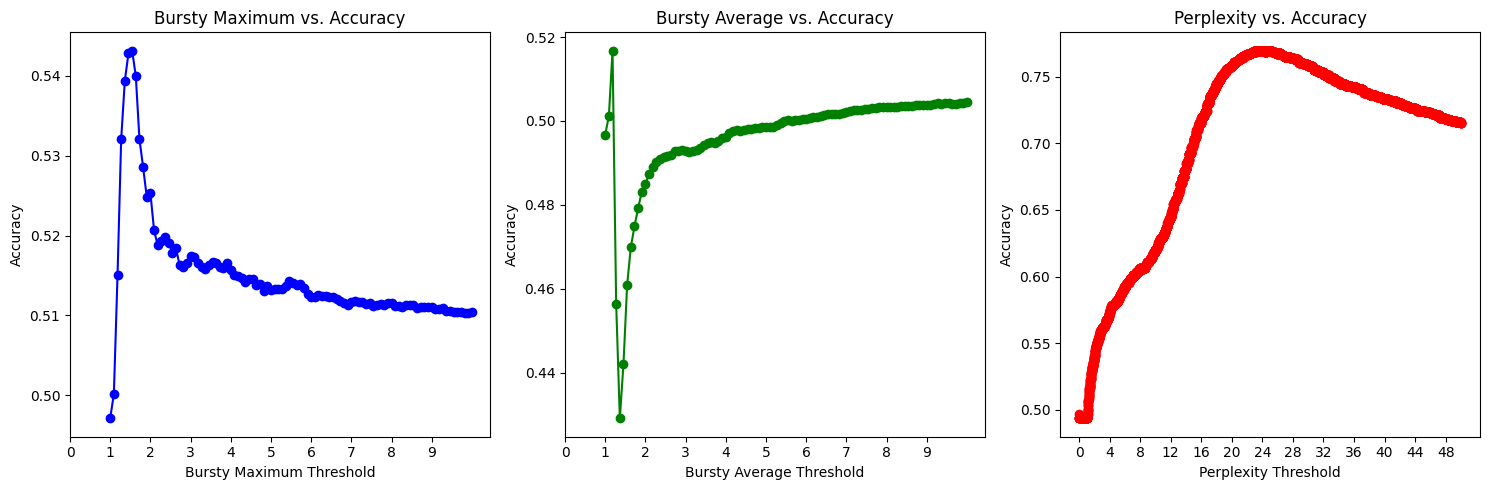

In [ ]:
plt.figure(figsize=(15, 5))

# Plot for bursty maximum perplexity threshold
plt.subplot(1, 3, 1)
plt.plot([x[0] for x in acc_bursty_max_pp_results], [x[1] for x in acc_bursty_max_pp_results], 'bo-')
plt.xlabel('Bursty Maximum Threshold')
plt.ylabel('Accuracy')
plt.title('Bursty Maximum vs. Accuracy')
plt.xticks(np.arange(0, 10, 1))

# Plot for bursty average perplexity threshold
plt.subplot(1, 3, 2)
plt.plot([x[0] for x in acc_bursty_avg_pp_results], [x[1] for x in acc_bursty_avg_pp_results], 'go-')
plt.xlabel('Bursty Average Threshold')
plt.ylabel('Accuracy')
plt.title('Bursty Average vs. Accuracy')
plt.xticks(np.arange(0, 10, 1))

# Plot for overall perplexity threshold
plt.subplot(1, 3, 3)
plt.plot([x[0] for x in acc_pp_results], [x[1] for x in acc_pp_results], 'ro-')
plt.xlabel('Perplexity Threshold')
plt.ylabel('Accuracy')
plt.title('Perplexity vs. Accuracy')
plt.xticks(np.arange(0, 50, 4))

plt.tight_layout()
plt.show()


In [ ]:
acc_bursty_max_pp

[0.5508333333333333,
 0.5358333333333334,
 0.5483333333333333,
 0.5316666666666666,
 0.5416666666666666]

In [ ]:
acc_bursty_avg_pp

[0.5054166666666666,
 0.5041666666666667,
 0.5033333333333333,
 0.4995833333333333,
 0.5033333333333333]

In [ ]:
acc_pp

[0.7720833333333333,
 0.7704166666666666,
 0.7775,
 0.7658333333333334,
 0.7616666666666667]

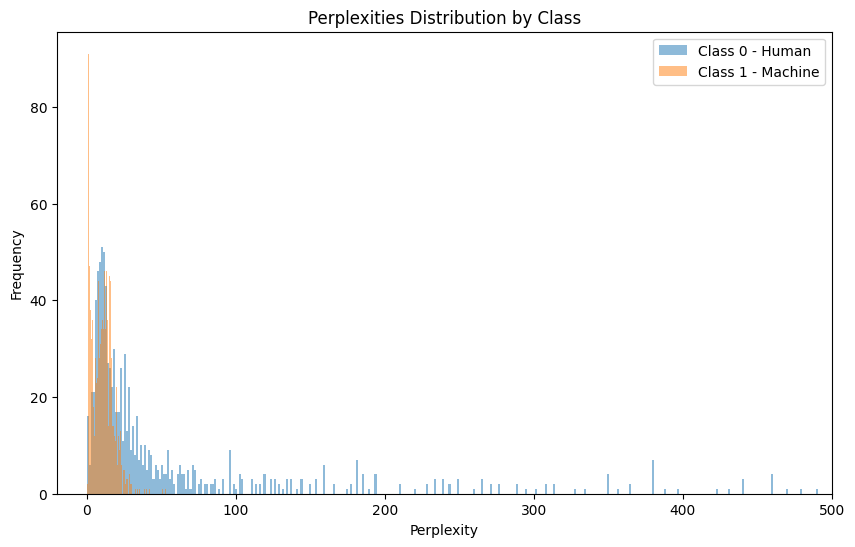

In [ ]:
plt.figure(figsize=(10, 6))
out1 = plt.hist(perplexities_class_0[0], bins=7000, alpha=0.5, label='Class 0 - Human')
out2 = plt.hist(perplexities_class_1[0], bins=100, alpha=0.5, label='Class 1 - Machine')
plt.xlabel('Perplexity')
plt.ylabel('Frequency')
plt.title('Perplexities Distribution by Class')
plt.legend()
plt.xlim(-20, 500)
plt.show()


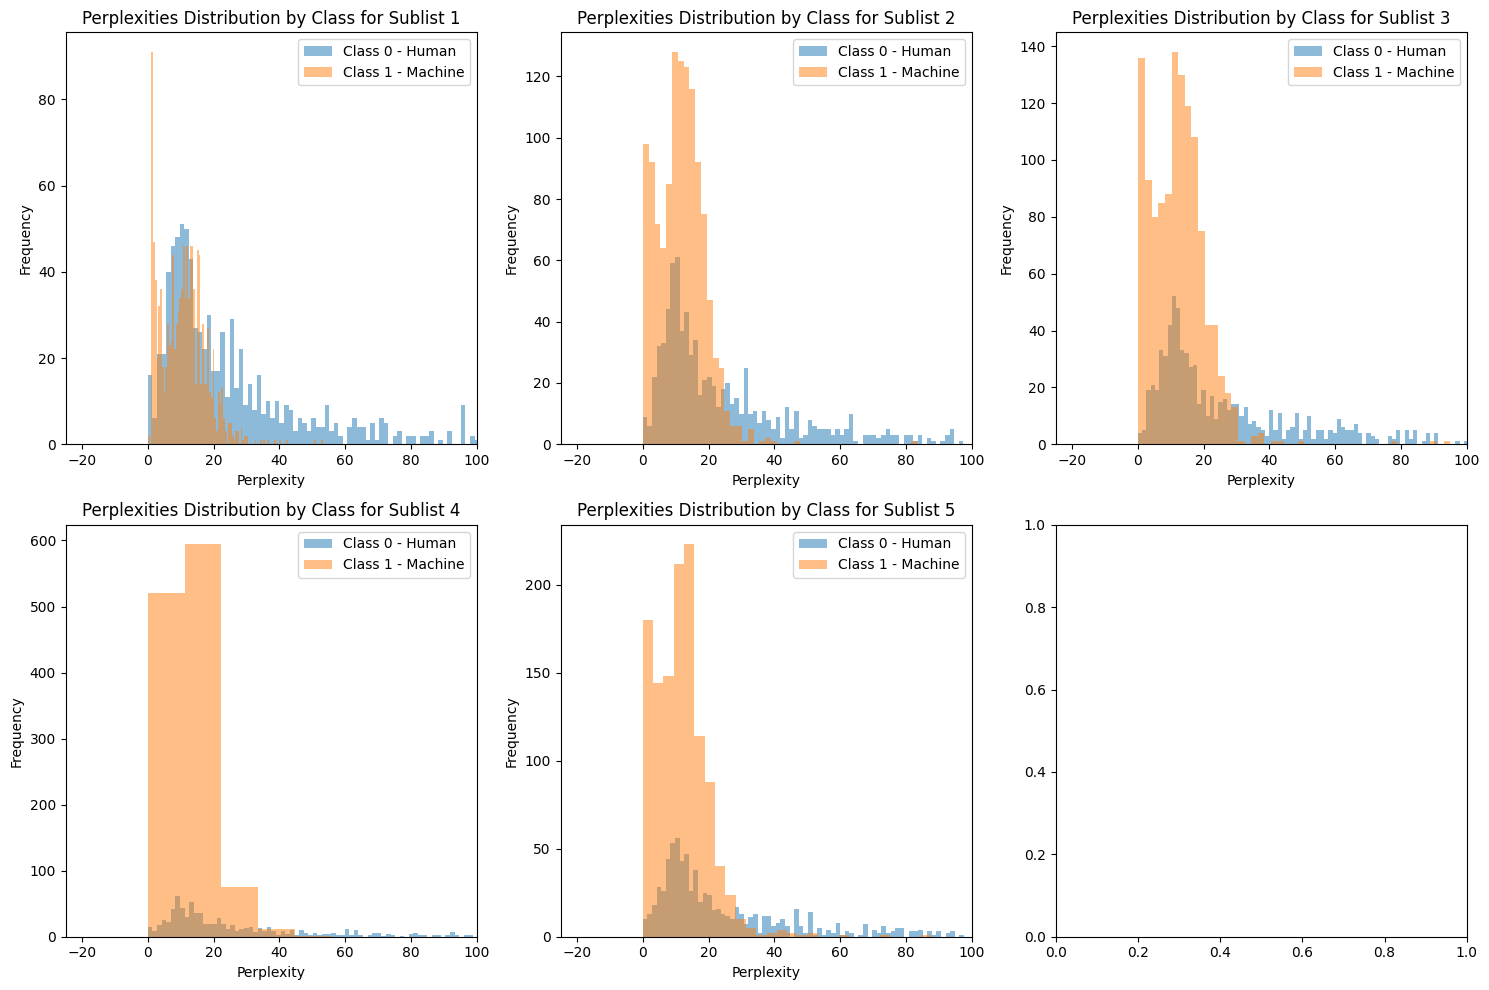

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i in range(len(perplexities_class_0)):
    row = i // 3
    col = i % 3
    axs[row, col].hist(perplexities_class_0[i], bins=7000, alpha=0.5, label='Class 0 - Human')
    axs[row, col].hist(perplexities_class_1[i], bins=100, alpha=0.5, label='Class 1 - Machine')
    axs[row, col].set_xlabel('Perplexity')
    axs[row, col].set_ylabel('Frequency')
    axs[row, col].set_title(f'Perplexities Distribution by Class for Sublist {i + 1}')
    axs[row, col].legend()
    axs[row, col].set_xlim(-25, 100)

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.kdeplot(perplexities_class_0[0], label='Human (Class 0)', fill=True, bw_adjust=1)
sns.kdeplot(perplexities_class_1[0], label='Machine (Class 1)', fill=True)
plt.xlabel('Perplexity')
plt.ylabel('Density')
plt.title('Class Distribution of Perplexities')
plt.legend(loc='upper right')
# plt.xlim(0, 100)
# plt.ylim(0, 1)
plt.show()


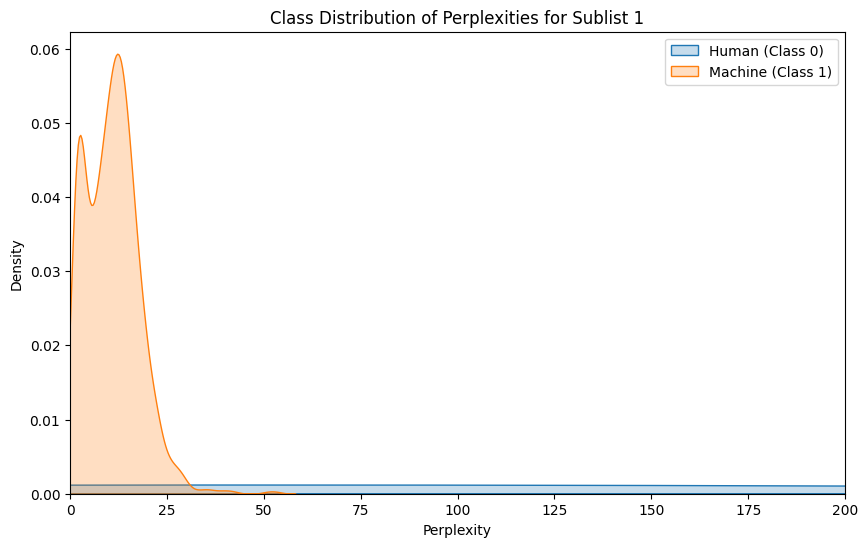

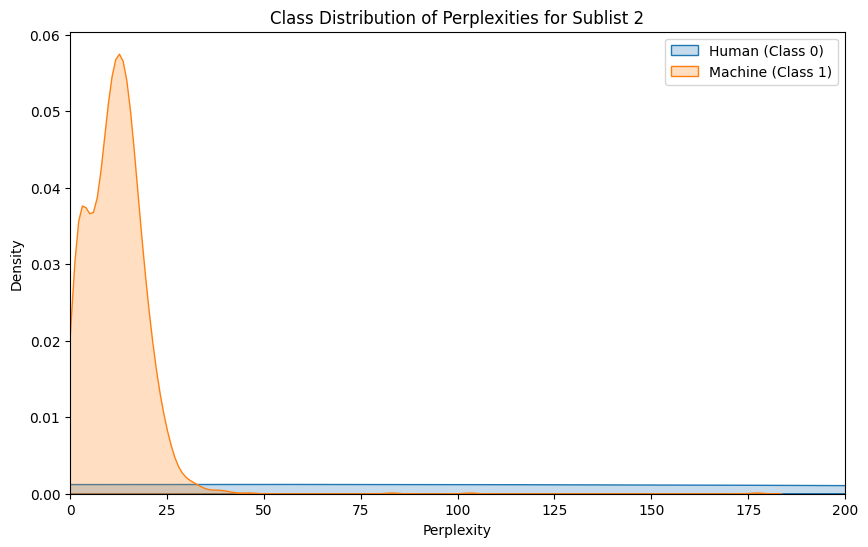

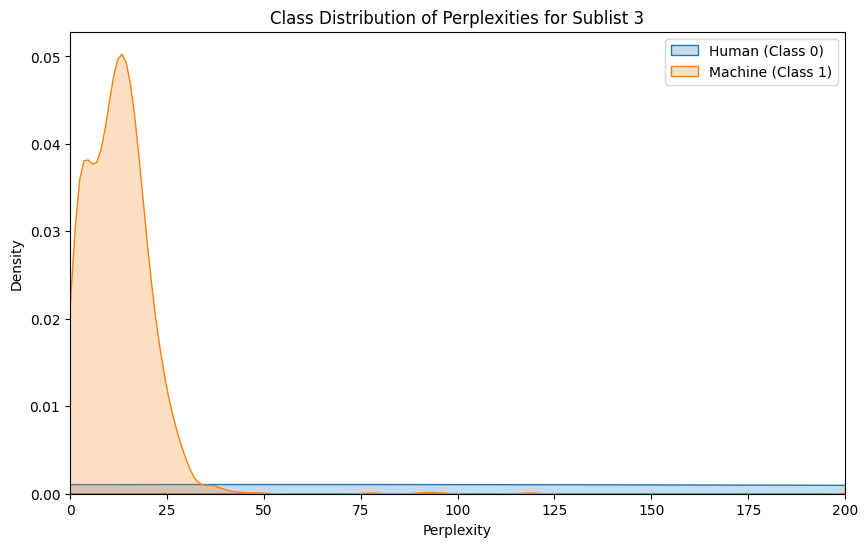

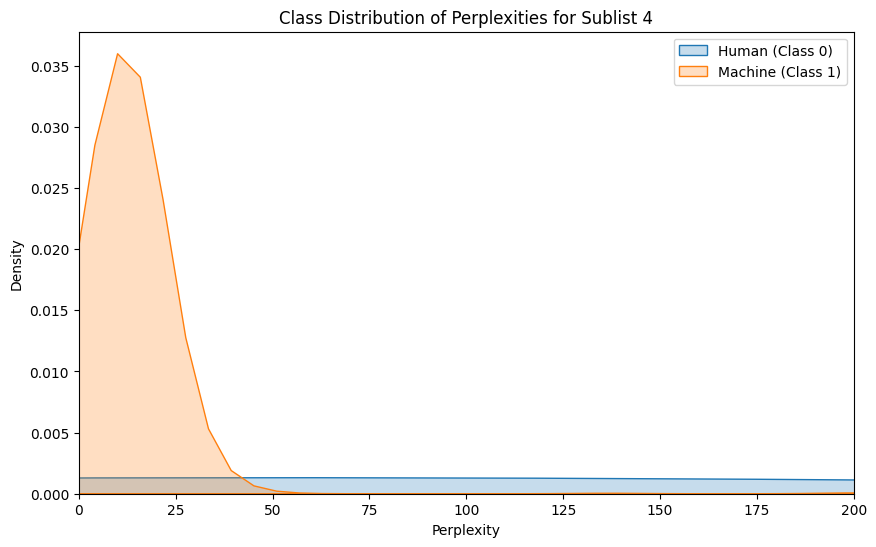

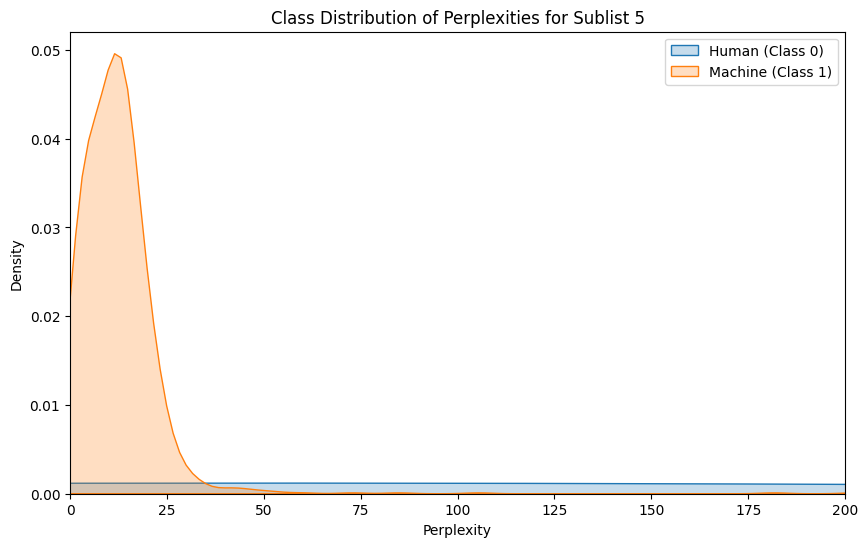

In [ ]:
# Loop through each sublist in results_pp
for i in range(len(perplexities_class_0)):

    # Plot the kdeplots for the current sublist
    plt.figure(figsize=(10, 6))
    sns.kdeplot(perplexities_class_0[i], label='Human (Class 0)', fill=True, bw_adjust = 1)
    sns.kdeplot(perplexities_class_1[i], label='Machine (Class 1)', fill=True)
    plt.xlabel('Perplexity')
    plt.ylabel('Density')
    plt.title(f'Class Distribution of Perplexities for Sublist {i + 1}')
    plt.legend(loc='upper right')
    plt.xlim(0, 200)
    plt.show()

